In [ ]:
import json
import os
import tempfile

import cmdstanpy
import matplotlib.pyplot as plt
import numpy as np

In [2]:
SEASONS = [*range(2025, 2026)]

data_path = os.path.join(os.getcwd(), "..", "..", "Data", "results", "processed")

players_mapping = {"None": 1}
players_time_on_match = {}
stan_data = {
    "home_players": [],
    "home_players_minutes": [],
    "away_players": [],
    "away_players_minutes": [],
    "home_goals": [],
    "away_goals": [],
}

for season in SEASONS:
    file_name = f"Serie_A_{season}_squads.json"
    with open(os.path.join(data_path, file_name)) as f:
        data = json.load(f)

    for game_data in data.values():
        home_goals, away_goals = list(
            map(int, game_data["Summary"]["Result"].upper().split(" X "))
        )
        del game_data["Summary"]
        home_players = {}
        away_players = {}
        for sub_game_data in game_data.values():
            if sub_game_data["Time"] == 0:
                continue

            sub_game_time = sub_game_data["Time"]
            for player in sub_game_data["Home"]["Squad"]:
                players_mapping[player] = players_mapping.setdefault(
                    player, len(players_mapping) + 1
                )
                players_time_on_match[player] = (
                    players_time_on_match.get(player, 0) + sub_game_time
                )
                home_players[player] = (
                    home_players.get(player, 0) + sub_game_data["Time"]
                )

            for player in sub_game_data["Away"]["Squad"]:
                players_mapping[player] = players_mapping.setdefault(
                    player, len(players_mapping) + 1
                )
                players_time_on_match[player] = (
                    players_time_on_match.get(player, 0) + sub_game_time
                )
                away_players[player] = (
                    away_players.get(player, 0) + sub_game_data["Time"]
                )

        if sum(home_players.values()) < 990:
            home_players["None"] = 990 - sum(home_players.values())
        if sum(away_players.values()) < 990:
            away_players["None"] = 990 - sum(away_players.values())

        stan_data["home_players"].append([players_mapping[x] for x in home_players])
        stan_data["home_players_minutes"].append(list(home_players.values()))
        stan_data["away_players"].append([players_mapping[x] for x in away_players])
        stan_data["away_players_minutes"].append(list(away_players.values()))
        stan_data["home_goals"].append(home_goals)
        stan_data["away_goals"].append(away_goals)

num_players_per_game = max(
    [len(x) for x in stan_data["home_players"]]
    + [len(x) for x in stan_data["away_players"]]
)

stan_data["num_games"] = len(stan_data["home_goals"])
stan_data["num_players"] = len(players_mapping)
stan_data["num_players_per_game"] = num_players_per_game

for i in range(stan_data["num_games"]):
    while len(stan_data["home_players"][i]) < num_players_per_game:
        stan_data["home_players"][i].append(1)
        stan_data["home_players_minutes"][i].append(0)
    while len(stan_data["away_players"][i]) < num_players_per_game:
        stan_data["away_players"][i].append(1)
        stan_data["away_players_minutes"][i].append(0)

In [3]:
STAN_CODE = """
data {
    int<lower=1> num_games;
    int<lower=1> num_players;
    int<lower=1> num_players_per_game;
    array[num_games, num_players_per_game] int<lower=1, upper=num_players> home_players;
    array[num_games, num_players_per_game] int<lower=1, upper=num_players> away_players;
    array[num_games, num_players_per_game] int<lower=0> home_players_minutes;
    array[num_games, num_players_per_game] int<lower=0> away_players_minutes;
    array[num_games] int<lower=0> home_goals;
    array[num_games] int<lower=0> away_goals;
}

transformed data {
    real log_90 = log(90);
}

parameters {
    vector[num_players - 1] raw_alpha;
    real nu;
}

transformed parameters {
    vector[num_players] alpha = append_row(-sum(raw_alpha), raw_alpha);
}

model {
    raw_alpha ~ normal(0, 1);
    nu ~ normal(0, 1);

    for (game in 1:num_games) {
        vector[num_players_per_game] log_terms_home;
        vector[num_players_per_game] log_terms_away;

        for (p in 1:num_players_per_game) {
            real mins_hp = home_players_minutes[game,p];
            real mins_ap = away_players_minutes[game,p];
            if (mins_hp > 0)
                log_terms_home[p] = alpha[home_players[game,p]] + log(mins_hp) - log_90;
            else
                log_terms_home[p] = negative_infinity();
            if (mins_ap > 0)
                log_terms_away[p] = alpha[away_players[game,p]] + log(mins_ap) - log_90;
            else
                log_terms_away[p] = negative_infinity();
        }

        real log_home_skill = log_sum_exp(log_terms_home);
        real log_away_skill = log_sum_exp(log_terms_away);

        real log_lambda_h = log_home_skill - log_away_skill + nu;
        real log_lambda_a = log_away_skill - log_home_skill;
        target += poisson_log_lpmf(home_goals[game] | log_lambda_h);
        target += poisson_log_lpmf(away_goals[game] | log_lambda_a);
    }
}

generated quantities {
    real log_lik = 0;
    for (game in 1:num_games) {
        vector[num_players_per_game] log_terms_home;
        vector[num_players_per_game] log_terms_away;

        for (p in 1:num_players_per_game) {
            real mins_hp = home_players_minutes[game,p];
            real mins_ap = away_players_minutes[game,p];
            if (mins_hp > 0)
                log_terms_home[p] = alpha[home_players[game,p]] + log(mins_hp) - log_90;
            else
                log_terms_home[p] = negative_infinity();
            if (mins_ap > 0)
                log_terms_away[p] = alpha[away_players[game,p]] + log(mins_ap) - log_90;
            else
                log_terms_away[p] = negative_infinity();
        }

        real log_home_skill = log_sum_exp(log_terms_home);
        real log_away_skill = log_sum_exp(log_terms_away);

        real log_lambda_h = log_home_skill - log_away_skill + nu;
        real log_lambda_a = log_away_skill - log_home_skill;
        log_lik += poisson_log_lpmf(home_goals[game] | log_lambda_h);
        log_lik += poisson_log_lpmf(away_goals[game] | log_lambda_a);
    }
}
"""

In [4]:
ranks = []
posterior_means = []
with tempfile.NamedTemporaryFile(mode="w", suffix=".stan", delete=False) as f:
    f.write(STAN_CODE)
    stan_file_path = f.name
try:
    model = cmdstanpy.CmdStanModel(stan_file=stan_file_path)
    fit = model.sample(
        data=stan_data,
        chains=1,
        iter_warmup=1_000,
        iter_sampling=1_000,
        show_progress=False,
    )

    samples = fit.stan_variables()
finally:
    os.unlink(stan_file_path)

00:13:56 - cmdstanpy - INFO - compiling stan file /private/var/folders/67/qnnhzk_15ydg7t3gr6_lmx8r0000gq/T/tmphzumqkzw.stan to exe file /private/var/folders/67/qnnhzk_15ydg7t3gr6_lmx8r0000gq/T/tmphzumqkzw
00:14:06 - cmdstanpy - INFO - compiled model executable: /private/var/folders/67/qnnhzk_15ydg7t3gr6_lmx8r0000gq/T/tmphzumqkzw
00:14:07 - cmdstanpy - INFO - CmdStan start processing
00:14:07 - cmdstanpy - INFO - Chain [1] start processing
00:15:19 - cmdstanpy - INFO - Chain [1] done processing
00:15:20 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 74 divergent transitions (7.4%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [5]:
fit.summary().describe()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
count,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000
mean,-1.636132,0.029924,0.976074,0.998504,-3.287056,-1.603947,-0.092312,1146.826735,647.307754,1.001534
std,45.168439,0.033982,0.645015,0.654618,45.977095,45.147668,44.413124,196.917489,101.652806,0.002724
min,-1385.330000,0.001450,0.046332,0.045197,-1418.110000,-1384.460000,-1354.790000,309.066000,254.384000,0.999000
25%,-0.102769,0.026475,0.903137,0.918314,-1.673077,-0.080541,1.348750,1018.092500,577.816500,0.999585
50%,0.014850,0.028361,0.949807,0.967654,-1.587305,0.030145,1.538870,1131.690000,653.723000,1.000590
75%,0.125803,0.030335,0.993520,1.018535,-1.492037,0.159019,1.705150,1264.370000,717.672000,1.002560
max,1.045490,1.070830,19.445800,20.200400,0.257746,1.200700,2.756990,2026.410000,901.226000,1.015320


In [6]:
draws = fit.draws_pd()
np.min(draws["nu"]), np.mean(draws["nu"]), np.max(draws["nu"])

(0.168238, 0.333130888, 0.474961)

In [7]:
cols = [f"alpha[{i}]" for i in range(1, stan_data["num_players"] + 1)]
params = (
    draws[cols]
    .describe()
    .T.reset_index()
    .rename(
        columns={
            "index": "player",
            0: "mean",
            1: "std",
            2: "min",
            3: "25%",
            4: "50%",
            5: "75%",
            6: "max",
        }
    )
)

params["player"] = params["player"].apply(
    lambda x: x.replace("alpha[", "").replace("]", "")
)
params["amplitude"] = params["max"] - params["min"]
reversed_players_mapping = {v: k for k, v in players_mapping.items()}
params["player_code"] = params["player"].apply(
    lambda x: reversed_players_mapping[int(x)]
)

params["time_played"] = params["player_code"].apply(
    lambda x: players_time_on_match.get(x, 0)
)

params.sort_values("mean", ascending=False)

,player,count,mean,std,min,25%,50%,75%,max,amplitude,player_code,time_played
3,4,1000.0,1.045490,1.168877,-2.50266,0.168241,1.200695,2.009970,3.218260,5.720920,310373,2954
1,2,1000.0,0.956384,1.177924,-3.53877,0.132953,1.010070,1.932107,3.146650,6.685420,815100,3330
80,81,1000.0,0.895566,1.125231,-3.43277,0.119481,1.024355,1.755235,3.291610,6.724380,297016,1689
76,77,1000.0,0.857159,1.065239,-2.53785,0.210390,0.934046,1.729995,2.903790,5.441640,458582,2875
416,417,1000.0,0.835138,1.207919,-2.81383,-0.013019,0.851641,1.738977,3.489960,6.303790,303716,1044
...,...,...,...,...,...,...,...,...,...,...,...,...
470,471,1000.0,-0.438857,0.815779,-3.44847,-0.971078,-0.405529,0.139572,1.669340,5.117810,419498,1456
403,404,1000.0,-0.469513,0.784956,-3.47133,-0.973836,-0.416948,0.079154,1.725950,5.197280,526090,1949
558,559,1000.0,-0.559153,0.790384,-3.41408,-1.090702,-0.512366,0.012907,1.497160,4.911240,337242,904
124,125,1000.0,-0.580570,0.767944,-3.59107,-1.092202,-0.537890,-0.023292,1.627370,5.218440,517052,1782


In [8]:
top_20 = np.argsort(np.mean(samples["alpha"], axis=0))[::-1][:20]
top_20_players = []
for player in top_20:
    for player_id in players_mapping:
        if players_mapping[player_id] == player + 1:
            force = np.mean(samples["alpha"][:, player])
            top_20_players.append((player_id, force))
            break

for i, (player, force) in enumerate(top_20_players):
    info = None
    for season in SEASONS[::-1]:
        file_name_games = f"Serie_A_{season}_games.json"
        with open(os.path.join(data_path, file_name_games)) as f:
            games = json.load(f)

        for game in games.values():
            players = game["Players"]
            for player_info in players:
                if player_info[0][-6:] == player:
                    info = player_info
                    break

            if info:
                break

        if info:
            break
    time_played = players_time_on_match.get(player, 0)
    print(i + 1, player, force, info, time_played)

1 310373 1.0454904594200003 ['4Leo Pereira Leonardo Pereira TP310373', 'Flamengo / RJ'] 2954
2 815100 0.9563837621600001 ['1ROSSI Agustin Daniel Rossi T(g)P815100', 'Flamengo / RJ'] 3330
3 297016 0.8955656498262 ['13Alex Telles Alex Nicolao Telles TP297016', 'Botafogo / RJ'] 1689
4 458582 0.8571586636859999 ['2Vitinho Victor Alexander da Silva TP458582', 'Botafogo / RJ'] 2875
5 303716 0.83513849183 ['9Pedro Pedro Guilherme Abre ... RP303716', 'Flamengo / RJ'] 1044
6 346636 0.83446508832 ['6Rene Rene Rodrigues Martins TP346636', 'Fluminense / RJ'] 2408
7 511021 0.8035340535000001 ['96Paulo Henr ... Paulo Henrique de Ol ... TP511021', 'Vasco da Gama / RJ'] 2492
8 546294 0.76784393015 ['88Christian Christian Roberto Al ... TP546294', 'Cruzeiro / MG'] 2387
9 292428 0.701400231319 ['2Samuel Xavier Samuel Xavier Brito RP292428', 'Fluminense / RJ'] 2344
10 548055 0.6834324354400001 ['30Pierre Wagner Pierre Wagner Olivei ... TP548055', 'Fortaleza / CE'] 840
11 176390 0.67185269618 ['2Marcos Ro

In [9]:
top_20 = np.argsort(np.mean(samples["alpha"], axis=0))[:20]
worst_20_players = []
for player in top_20:
    for player_id in players_mapping:
        if players_mapping[player_id] == player + 1:
            force = np.mean(samples["alpha"][:, player])
            worst_20_players.append((player_id, force))
            break

for i, (player, force) in enumerate(worst_20_players):
    info = None
    for season in SEASONS[::-1]:
        file_name_games = f"Serie_A_{season}_games.json"
        with open(os.path.join(data_path, file_name_games)) as f:
            games = json.load(f)

        for game in games.values():
            players = game["Players"]
            for player_info in players:
                if player_info[0][-6:] == player:
                    info = player_info
                    break

            if info:
                break

        if info:
            break
    time_played = players_time_on_match.get(player, 0)
    print(i + 1, player, force, info, time_played)

1 None -22.328077705800002 None 0
2 517052 -0.58056959761 ['33Matheus Al ... Matheus Alexandre An ... RP517052', 'Sport / PE'] 1782
3 337242 -0.559152914414 ['21Lucas Lucas Kal Schenfeld  ... TP337242', 'Sport / PE'] 904
4 526090 -0.469512958158 ['2Ramon Ramon Ramos Lima RP526090', 'Internacional / RS'] 1949
5 419498 -0.43885690144699996 ['34Rodrigo Sam Rodrigo Eduardo da Silva RP419498', 'Juventude / RS'] 1456
6 331937 -0.43619717059 ['10Lucas Lima Lucas Rafael Araujo Lima TP331937', 'Sport / PE'] 2549
7 321898 -0.426645356934 ['6Pepe Joao Pedro Vilardi Pinto TP321898', 'Vitória / BA'] 608
8 313131 -0.42573204773400003 ['22Caique Caique Franca Godoy T(g)P313131', 'Sport / PE'] 1350
9 500506 -0.425553930697 ['2Ewerthon Ewerthon Diogenes da ... TP500506', 'Juventude / RS'] 1110
10 540157 -0.42083863018 ['36Luan Candido Luan Candido de Almeida RP540157', 'Grêmio / RS'] 1317
11 337840 -0.41377504458 ['79Renato Kayzer Renato Kayzer de Souza RP337840', 'Vitória / BA'] 2042
12 187597 -0.4125

In [30]:
df = params[["player", "mean", "time_played"]].copy()
file_name_games = "Serie_A_2025_games.json"
with open(os.path.join(data_path, file_name_games)) as f:
    games = json.load(f)

for player in df["player"].values[1:]:
    info = None
    for player_id in players_mapping:
        if player_id == "None":
            continue
        if players_mapping[player_id] == int(player):
            df.loc[df["player"] == player, "player_id"] = player_id
            break

    for game in games.values():
        players = game["Players"]
        for player_info in players:
            if player_info[0][-6:] == player_id:
                info = player_info
                df.loc[df["player_id"] == player_id, "player_name"] = player_info[0]
                df.loc[df["player_id"] == player_id, "team_name"] = player_info[1]
                break

        if info:
            break


df.dropna(inplace=True)
df

,player,mean,time_played,player_id,player_name,team_name
1,2,0.956384,3330,815100,1ROSSI Agustin Daniel Rossi T(g)P815100,Flamengo / RJ
2,3,0.286121,2248,422469,3Léo Ortiz Leonardo Rech Ortiz TP422469,Flamengo / RJ
3,4,1.045490,2954,310373,4Leo Pereira Leonardo Pereira TP310373,Flamengo / RJ
4,5,0.119001,1241,777370,5Erick Pulgar Erick Antonio Pulgar ... TP777370,Flamengo / RJ
5,6,0.553068,1712,424455,7Luiz Luiz de Araujo Guima ... TP424455,Flamengo / RJ
...,...,...,...,...,...,...
727,728,0.045206,22,696436,76Wanderson ... Wanderson Junior de ... RP69...,Flamengo / RJ
728,729,0.052401,22,687260,72LUCAS Lucas Vieira dos Santos RP687260,Flamengo / RJ
729,730,0.071879,17,622161,80João João Paulo Camargo d ... RP622161,Flamengo / RJ
730,731,-0.137673,56,647416,66Leandrinho Leandro Viana da Sil ... RP647416,Vasco da Gama / RJ


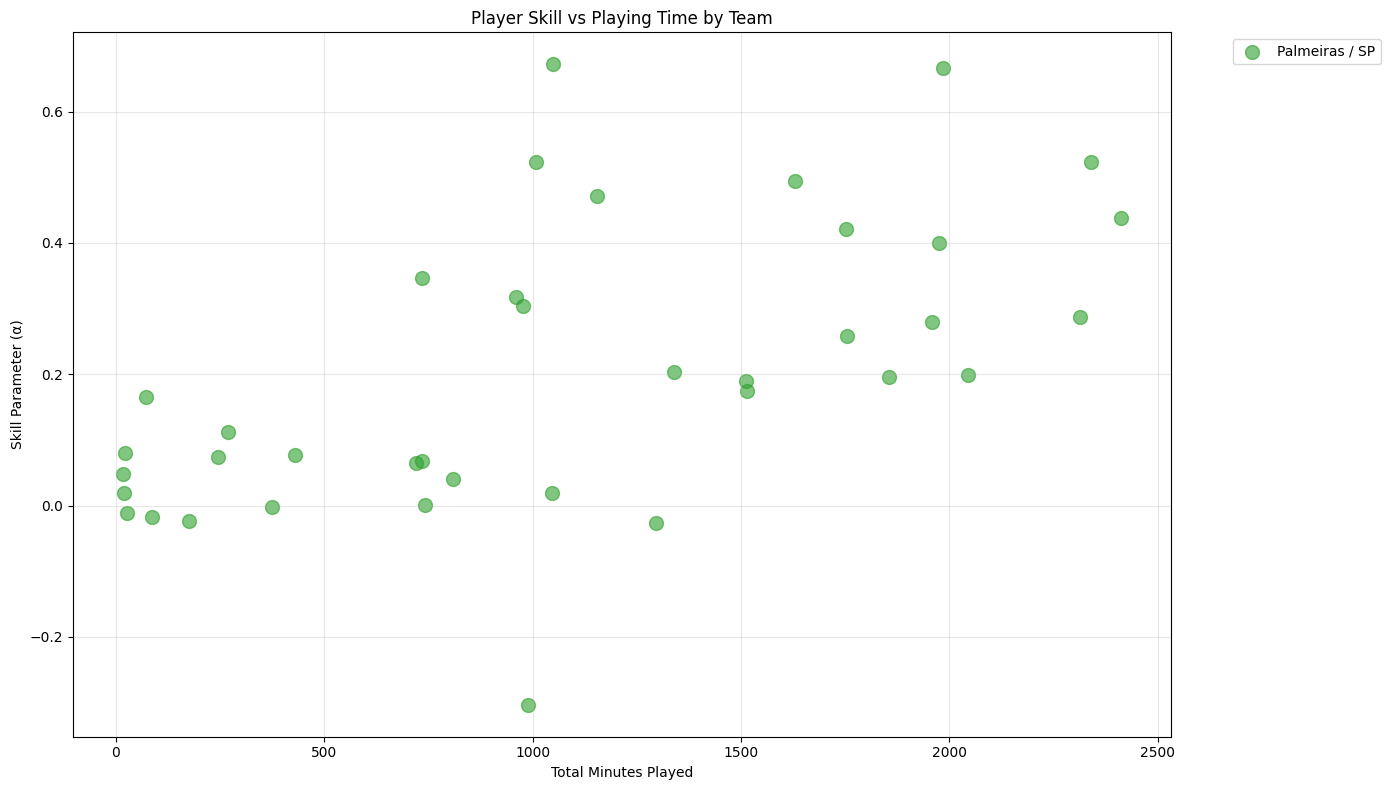

In [34]:
plt.figure(figsize=(14, 8))
teams = df["team_name"].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(teams)))
team_color_map = dict(zip(teams, colors, strict=False))

for team in teams:
    if team != "Palmeiras / SP":
        continue
    team_data = df[df["team_name"] == team]
    plt.scatter(
        team_data["time_played"],
        team_data["mean"],
        label=team,
        alpha=0.6,
        s=100,
        c=[team_color_map[team]],
    )

plt.xlabel("Total Minutes Played")
plt.ylabel("Skill Parameter (α)")
plt.title("Player Skill vs Playing Time by Team")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()